In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import time
import glob
import warnings
warnings.filterwarnings('ignore')


#data
path = "./data/data_daily"
all_files = glob.glob(path + "/*.csv")   #把所有的数据文件文件名读取在一起

li = []


for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)


frame = pd.concat(li, axis=0, ignore_index=True)
result_df = frame.sort_values(by=['code', 'date'], ascending=True)

100%|██████████| 949/949 [00:40<00:00, 23.66it/s]


In [2]:
result_df = result_df.reset_index(drop=True)
result_df

,date,code,open,close,low,high,volume,money,turnover_ratio
0,2020-01-02,000001.XSHE,1976.78,2002.90,1964.91,2012.40,1288881.0,2.571196e+09,0.7885
1,2020-01-03,000001.XSHE,2011.21,2039.71,2008.84,2055.14,940146.0,1.914495e+09,0.5752
2,2020-01-06,000001.XSHE,2019.52,2026.65,2007.65,2058.70,726114.0,1.477930e+09,0.4442
3,2020-01-07,000001.XSHE,2033.77,2036.14,2012.40,2051.58,613690.0,1.247047e+09,0.3755
4,2020-01-08,000001.XSHE,2018.34,1977.97,1974.41,2024.27,714104.0,1.423609e+09,0.4369
...,...,...,...,...,...,...,...,...,...
4253855,2023-11-24,689009.XSHG,34.88,35.28,34.88,35.88,10815571.0,3.834648e+08,2.0661
4253856,2023-11-27,689009.XSHG,35.24,34.89,34.62,35.60,6348515.0,2.225542e+08,1.2128
4253857,2023-11-28,689009.XSHG,34.90,34.36,34.01,35.17,5755962.0,1.979950e+08,1.0996
4253858,2023-11-29,689009.XSHG,34.59,33.27,33.09,34.59,6423819.0,2.155980e+08,1.2271


In [3]:
%%time
grouped = result_df.groupby('code').apply(lambda x: x[['close', 'turnover_ratio']].rolling(10).corr().iloc[0::2]['turnover_ratio'])

CPU times: total: 3min 15s
Wall time: 3min 18s


In [5]:
grouped = grouped.reset_index(level=[0,1])
grouped = grouped.drop(columns=['level_1'])
grouped.index = range(len(grouped))
grouped['date'] = result_df['date']
grouped.columns = ['code','factor','date']
grouped['factor'] *= -1

IndexError: Too many levels: Index has only 1 level, not 2

In [6]:
grouped.tail()

,code,factor,date
4253855,689009.XSHG,-0.352872,2023-11-24
4253856,689009.XSHG,-0.462647,2023-11-27
4253857,689009.XSHG,-0.556800,2023-11-28
4253858,689009.XSHG,-0.613029,2023-11-29
4253859,689009.XSHG,-0.622192,2023-11-30


In [7]:
#将日期列转换为datetime类型
df = grouped
df['date']=pd.to_datetime(df['date'])

#保存文件夹路径
output_folder='./new_feature/factor_1_6'
selected_columns=['code', 'date', 'factor']

os.makedirs(output_folder,exist_ok=True)

#创建日期索引并检查是否在dateframe中存在
date_index=pd.date_range(df['date'].min(),df['date'].max(),freq='D')
existing_dates=[d for d in date_index if d in df['date'].values]

#遍历每个日期如果它在dataframe中存在 则将其保存为单独的csv文件
for date in tqdm(existing_dates):
    group=df.loc[df['date']==date,selected_columns]
    filename=os.path.join(output_folder,f'{date.strftime("%Y-%m-%d")}.csv')
    group=group.sort_values(by='code',ascending=True)
    group = group.drop(columns = ['date'])
    group.to_csv(filename,index=False)

100%|██████████| 949/949 [02:15<00:00,  6.99it/s]


100%|██████████| 949/949 [01:41<00:00,  9.37it/s]


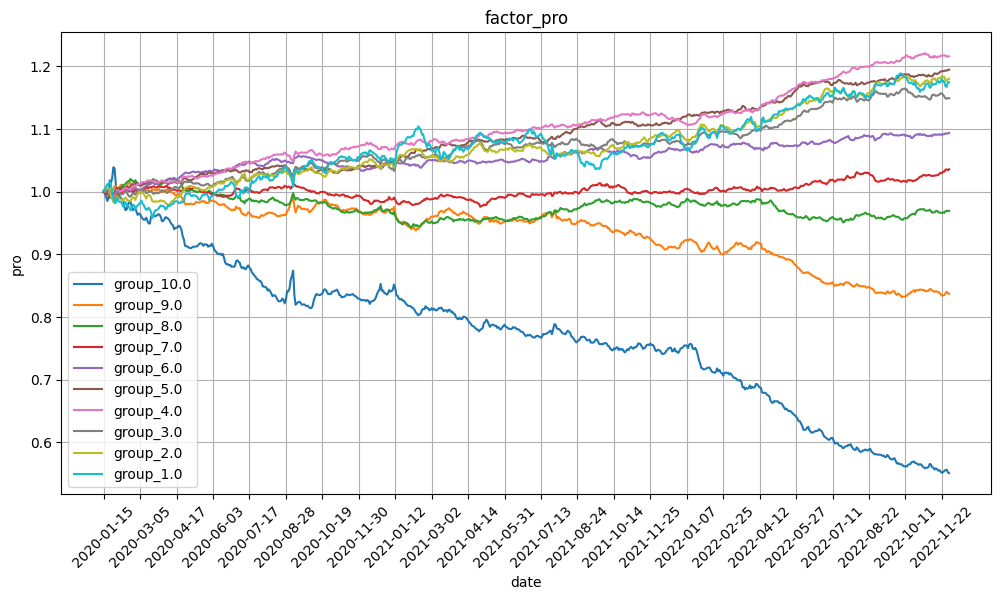

,factor_name,ic:,icir:,多头收益率:,多头波动率:,多头ir:,多头最大回撤:,对冲收益率:,对冲波动率:,对冲ir:,对冲最大回撤:
0,factor,0.01,0.139,0.165,0.193,0.854,27.1,0.273,0.114,2.403,8.9


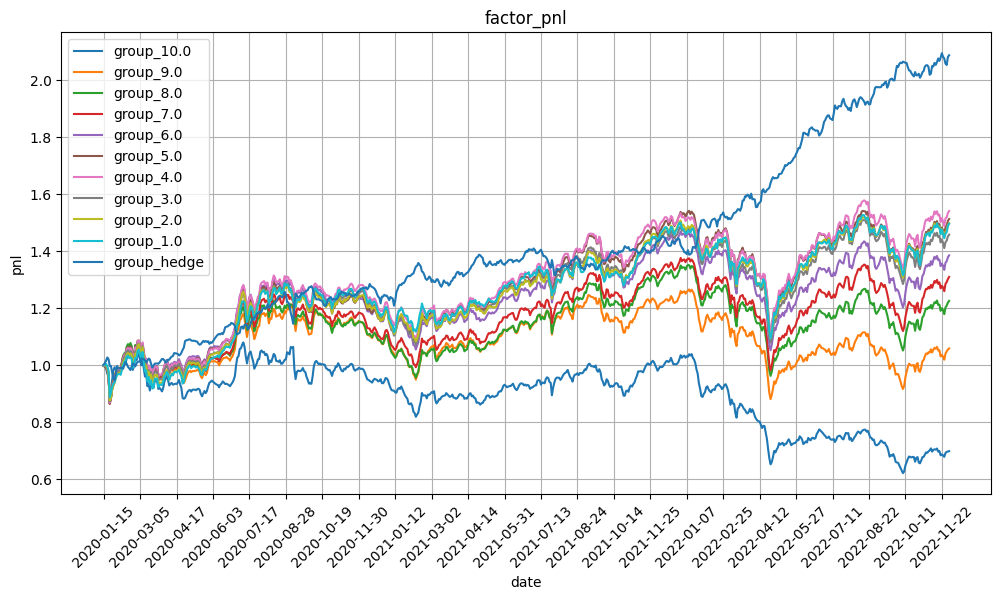

In [12]:
from backtest import BacktestAnalyzer
start_date = '2020-01-01'
end_date = '2022-11-30'
trade_date = './data/date.pkl'
factor_path = './new_feature/factor_1_6'
ret_path = './data/data_ret'
ud_path = './data/data_ud_new'
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

analyzer = BacktestAnalyzer(start_date, end_date, trade_date, factor_path, ret_path, ud_path, group)
analyzer.prepare_data()
analyzer.calculate_effectiveness()
analyzer.result